In [2]:
import sys
sys.path.append('../scripts/')

from time import time
import glob
import warnings
import param

import numpy as np
import pandas as pd
import xarray as xr
from scipy.special import gammaln
from scipy.optimize import curve_fit, minimize

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

from epsilon_tools import *
from tools import str2date, avg_funs

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='paper', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

%matplotlib inline

In [3]:
# probably also needs: jupyter labextension install @pyviz/jupyterlab_pyviz
# jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [57]:
def prepare_data(tms, ctd):
    ''' 
    Procedure to calculate chi from EM-APEX float

    see: RC's write-up "EM-APEX Turbulence Measurements"
    '''

    # % 1) convert realtime-transmitted scaled spectrum (sla)
    # to digitized voltage Spectrum
    tms['slad1'] = (tms.sla1 - tms.logavgoff) / tms.logavgsf
    tms['slad2'] = (tms.sla2 - tms.logavgoff) / tms.logavgsf

    # % 2) convert to raw spectrum of temperature
    beta = 25
    Vref = 4  # volt
    Inet = 0.8
    scale2 = (beta * Vref / (2**23 * Inet))**2
    tms['rawTsp1'] = 10**(tms.slad1 / 10) * scale2
    tms['rawTsp2'] = 10**(tms.slad2 / 10) * scale2

    # % 3) get background T,N,P,W, and dT/dz from ctd
    tms['p'] = ctd.p.interp(time=tms.time)
    tms['N2'] = ctd.N2.interp(time=tms.time)
    tms['N'] = np.abs(np.sqrt(tms['N2']))
    tms['T'] = ctd.T.interp(time=tms.time)
    tms['dTdz'] = ctd.dTdz.interp(time=tms.time)
    tms['w'] = np.abs(ctd.w.interp(time=tms.time))

    # convert to wavenumber
    tms['k_cpm'] = tms.f_cps / tms.w
    tms['f_rps'] = tms.f_cps * 2 * np.pi
    tms['k_rpm'] = tms.f_rps / tms.w
    tms = tms.set_coords('k_rpm')

    # % 4) compute transfer functions and compute corrected T spectrum
    tms['H2adc'] = H2ADCfun(tms.f_cps)
    tms['H2preamp'] = H2preampfun(tms.f_cps)
    tms['H2fp07'] = H2FP07fun(tms.f_cps, tms.w)
    tms['H2total_cps'] = tms.H2adc * tms.H2preamp * tms.H2fp07
    tms['corrTsp1_cps'] = tms.rawTsp1 / tms.H2total_cps
    tms['corrTsp2_cps'] = tms.rawTsp2 / tms.H2total_cps
    
    # % 5) remove noise Spectrum
    #     threshold = 4
    #     tms = remove_noise_sp(tms, threshold) 
    
    tms['noise_cps'] = noise_sp(tms.f_cps)
    
    # compute signal-to-noise ratio
    tms['snr1'] = tms.corrTsp1_cps/tms.noise_cps
    tms['snr2'] = tms.corrTsp2_cps/tms.noise_cps 

    # % 6) convert temperature frequency to wavenumber spectrum
    tms['corrTsp1_rpm'] = tms.corrTsp1_cps * tms.w / (2 * np.pi)
    tms['corrTsp2_rpm'] = tms.corrTsp2_cps * tms.w / (2 * np.pi)
    
    tms['corrdTdzsp1_rpm'] = tms.k_rpm**2 * tms.corrTsp1_rpm
    tms['corrdTdzsp2_rpm'] = tms.k_rpm**2 * tms.corrTsp2_rpm
    
    #tms = tms.drop(
    #    ['slad1', 'slad2', 'rawTsp1', 'rawTsp2','logavgsf','logavgoff','sla1','sla2'])
    return tms

def compute_chi(tms, p):
    # % 7) compute chi, kT, and eps1    
    tms['noise_rpm'] = tms.k_rpm**2*tms.noise_cps*tms.w/(2*np.pi)
    
    tms = tms.swap_dims({'f_cps': 'k_rpm'})
#     condition = (tms.k_rpm <= p.kzmax) & (tms.k_rpm >= p.kzmin)

    cond1 = tms.snr1 > p.snrmin
    cond2 = tms.snr2 > p.snrmin

    if cond1.sum() >= 3:
        tms['chi1'] = 6 * p.D * (tms.corrdTdzsp1_rpm - tms.noise_rpm).where(cond1).dropna(
            dim='k_rpm').integrate('k_rpm')

        tms['isnr1'] = tms.snr1.where(cond1).dropna(
            dim='k_rpm').integrate('k_rpm')
    else:
        tms['chi1'] = np.nan
        tms['isnr1'] = np.nan
    
    if cond1.sum() >= 3:
        tms['chi2'] = 6 * p.D * (tms.corrdTdzsp2_rpm - tms.noise_rpm).where(cond2).dropna(
            dim='k_rpm').integrate('k_rpm')
        tms['isnr2'] = tms.snr2.where(cond2).dropna(
            dim='k_rpm').integrate('k_rpm')
    else:
        tms['chi2'] = np.nan
        tms['isnr2'] = np.nan
        
    return tms

def compute_rc_eps(tms, p):
    ''' 
    Assume mixing efficiency and compute eps using background dTdz, N2, and chi
    
    see Ren-Chieh's document, 1992
    '''
    import xarray as xr
    
    tms['kt1'] = 0.5 * tms.chi1 / tms.dTdz**2
    tms['eps1_rc'] = tms.kt1 * tms.N2 / p.gamma
    tms['kb1_rc'] = (tms.eps1_rc / p.nu / p.D**2)**(0.25)
    
    tms['kt2'] = 0.5 * tms.chi2 / tms.dTdz**2
    tms['eps2_rc'] = tms.kt2 * tms.N2 / p.gamma
    tms['kb2_rc'] = (tms.eps2_rc / p.nu / p.D**2)**(0.25)
    
    tms['bat1_rc'] = batchelor(tms.k_rpm, tms.chi1, tms.kb1_rc, p)
    tms['bat2_rc'] = batchelor(tms.k_rpm, tms.chi2, tms.kb2_rc, p)

    return tms

def compute_goto_eps(tms, p):
    '''
    Method after Ruddick et al, 1996 and Goto et al., 2016
    
    Requires computation of chi.
    '''

    def cost_function(kb, k_rpm, chi, noise, corrdTdz, function, p):
        '''
        Cost function for MLE to fit spectra
        '''
        import bottleneck as bn
        
        def chisquared(x,df,gammadf):
            from scipy.special import xlogy
            import math
            import numpy as np
            return np.exp( xlogy(df/2-1, x) - x/2 - gammadf - (math.log(2)*df)/2 )

        if function.lower() == 'batchelor':
            theory = batchelor(k_rpm, chi, kb, p)
        elif function.lower() == 'kraichnan':
            theory = kraichnan(k_rpm, chi, kb, p)
        else:
            raise ValueError('Function not known!')

        a = p.dof / (theory + noise)
        b = chisquared(corrdTdz * a, p.dof, p.gammadf)
        c = np.log(a * b)

        return -bn.nansum(c)
    
#     condition = (tms.k_rpm <= p.kzmax) & (tms.k_rpm >= p.kzmin)
    
    cond1 = tms.snr1 > p.snrmin
    cond2 = tms.snr2 > p.snrmin

    chi1 = tms.where(cond1).chi1.values
    chi2 = tms.where(cond2).chi2.values
    noise = tms.where(cond1).noise_rpm.values
    k_rpm = tms.where(cond1).k_rpm.values
    dtdz1 = tms.where(cond1).corrdTdzsp1_rpm.values
    dtdz2 = tms.where(cond2).corrdTdzsp2_rpm.values

    bounds =[(200,1000)]
    args = (k_rpm, chi1, noise, dtdz1, 'Batchelor', p)
    m = minimize(cost_function, x0=p.x0, args=args, method='Nelder-Mead', bounds=bounds)
    tms['kb1_bat'] = m.x[0]
    tms['l1_bat'] = -m.fun
    
    args = (k_rpm, chi2, noise, dtdz2, 'Batchelor', p)
    m = minimize(cost_function, x0=p.x0, args=args, method='Nelder-Mead', bounds=bounds)
    tms['kb2_bat'] = m.x[0]
    tms['l2_bat'] = -m.fun

    args = (k_rpm, chi1, noise, dtdz1, 'Kraichnan', p)
    m = minimize(cost_function, x0=p.x0, args=args, method='Nelder-Mead', bounds=bounds)
    tms['kb1_kra'] = m.x[0]
    tms['l1_kra'] = -m.fun
    
    args = (k_rpm, chi2, noise, dtdz2, 'Kraichnan', p)
    m = minimize(cost_function, x0=p.x0, args=args, method='Nelder-Mead', bounds=bounds)
    tms['kb2_kra'] = m.x[0]
    tms['l2_kra'] = -m.fun
    
    tms['eps1_bat'] = tms['kb1_bat']**4 * p.nu * p.D**2
    tms['eps2_bat'] = tms['kb2_bat']**4 * p.nu * p.D**2  #* (2 * np.pi)**4

    tms['eps1_kra'] = tms['kb1_kra']**4 * p.nu * p.D**2
    tms['eps2_kra'] = tms['kb2_kra']**4 * p.nu * p.D**2
    
    tms['bat1'] = batchelor(tms.k_rpm, tms.chi1, tms.kb1_bat, p)
    tms['bat2'] = batchelor(tms.k_rpm, tms.chi2, tms.kb2_bat, p)
    
    tms['kra1'] = kraichnan(tms.k_rpm, tms.chi1, tms.kb1_kra, p)
    tms['kra2'] = kraichnan(tms.k_rpm, tms.chi2, tms.kb2_kra, p)

    tms['y_bat1'] = dtdz1/( tms.bat1 + noise)  
    tms['y_bat2'] = dtdz2/( tms.bat2 + noise)  
    tms['y_kra1'] = dtdz1/( tms.kra1 + noise)  
    tms['y_kra2'] = dtdz2/( tms.kra2 + noise)  
    
    return tms

def compute_likelihood_ratio(tms, p):
    '''
    Fit power law of the from Ak**(-b) to the temperature gradient spectrum
    '''

    def cost_function_power(kb, k_rpm, noise, corrdTdz, p):
        '''
        Cost function for MLE to fit spectra
        '''
        import bottleneck as bn

        def chisquared(x, df, gammadf):
            from scipy.special import xlogy
            import math
            import numpy as np
            return np.exp( xlogy(df/2-1, x) - x/2 - gammadf - (math.log(2)*df)/2 )

        theory = kb[0]*k_rpm**(-kb[1])
        a = p.dof / (theory + noise)
        b = chisquared(corrdTdz * a, p.dof, p.gammadf)
        c = np.log(a * b)

        return -bn.nansum(c)
    
#     condition = (tms.k_rpm <= p.kzmax) & (tms.k_rpm >= p.kzmin)
    cond1 = tms.snr1 > p.snrmin
    cond2 = tms.snr2 > p.snrmin
    
    noise = tms.where(cond1).noise_rpm.values
    k_rpm = tms.where(cond1).k_rpm.values
    dtdz1 = tms.where(cond1).corrdTdzsp1_rpm.values
    dtdz2 = tms.where(cond2).corrdTdzsp2_rpm.values
    
    bounds = [(1e-1,1e-9),(-10,10)]  
    m = minimize(cost_function_power, x0=[np.nanmean(dtdz1),0], args=(k_rpm, noise, dtdz1, p), method='Nelder-Mead')
    tms['A1'],tms['b1'] = m.x
#     tms['A1'] = np.exp( np.log(np.nanmean( dtdz1)) - tms.b1*np.log(np.nanmean(k_rpm)) )
    tms['l1'] = -m.fun
    
    m = minimize(cost_function_power, x0=[np.nanmean(dtdz2),0], args=(k_rpm, noise, dtdz2, p), method='Nelder-Mead')
    tms['A2'],tms['b2'] = m.x
#     tms['A2'] = np.exp( np.log(np.nanmean( dtdz2)) - tms.b2*np.log(np.nanmean(k_rpm)) )
    tms['l2'] = -m.fun
    
    tms['lhr1_bat'] = tms.l1_bat-tms.l1
    tms['lhr2_bat'] = tms.l2_bat-tms.l2
    
    tms['lhr1_kra'] = tms.l1_kra-tms.l1
    tms['lhr2_kra'] = tms.l2_kra-tms.l2
    
    tms['power1'] = tms.A1*tms.k_rpm**(-tms.b1)
    tms['power2'] = tms.A2*tms.k_rpm**(-tms.b2)
    return tms

def mad(tms, p):
    ''' 
    Compute Maximum Absolute Deviation
    (here based on mean) and averaged for wavenumbers where SNR is large
    '''
    
    def max_abs_dev(ds):
        import bottleneck as bn
        return bn.nanmean( np.abs( ds  - bn.nanmean(ds)) )
    
    cond1 = tms.snr1 > p.snrmin
    cond2 = tms.snr2 > p.snrmin
    
    th_bat1 = batchelor(tms.k_rpm, tms.chi1, tms.kb1_bat, p) + tms.noise_rpm
    th_bat2 = batchelor(tms.k_rpm, tms.chi2, tms.kb2_bat, p) + tms.noise_rpm
    
    th_kra1 = kraichnan(tms.k_rpm, tms.chi1, tms.kb1_kra, p) + tms.noise_rpm
    th_kra2 = kraichnan(tms.k_rpm, tms.chi2, tms.kb2_kra, p) + tms.noise_rpm
    
    th_rc1 = batchelor(tms.k_rpm, tms.chi1, tms.kb1_rc, p) + tms.noise_rpm
    th_rc2 = batchelor(tms.k_rpm, tms.chi2, tms.kb2_rc, p) + tms.noise_rpm
    
    ratio_bat1 = (tms.corrdTdzsp1_rpm/th_bat1).where(cond1)
    ratio_bat2 = (tms.corrdTdzsp2_rpm/th_bat2).where(cond2)
    ratio_kra1 = (tms.corrdTdzsp1_rpm/th_kra1).where(cond1)
    ratio_kra2 = (tms.corrdTdzsp2_rpm/th_kra2).where(cond2)
    ratio_rc1 = (tms.corrdTdzsp1_rpm/th_rc1).where(cond1)
    ratio_rc2 = (tms.corrdTdzsp2_rpm/th_rc2).where(cond2)
    
    tms['mad1_bat'] = max_abs_dev( ratio_bat1 )
    tms['mad2_bat'] = max_abs_dev( ratio_bat2 )
    
    tms['mad1_kra'] = max_abs_dev( ratio_kra1 )
    tms['mad2_kra'] = max_abs_dev( ratio_kra2 )
    
    tms['mad1_rc'] = max_abs_dev( ratio_rc1 )
    tms['mad2_rc'] = max_abs_dev( ratio_rc2 )
    return tms

def qc_rc_eps(data, p):
    '''
    clean chi and eps with RC's scripts
    '''
    floats = np.array([
        '7779a', '7781a', '7783a', '7786a', '7787a', '7788a',
        '7700b', '7701b','7780b', '7784b', '7785b', '7786b'
    ])
    fi = np.where(floats == data.floatid)[0][0]
    good_chi1, good_chi2 = np.load('../data/good_chi.npy')

    # 1) thresholds for chi
    data['dtdz1'] = np.sqrt(0.5 * data.chi1 / data.kt1)
    data['dtdz2'] = np.sqrt(0.5 * data.chi2 / data.kt2)

    bad = (data.dtdz1 <= p.dtdzmin) | (data.chi1 >= p.chimax) | (data.kt1 >= p.kTmax) #| (data.z > zmin)
    data['chi1'] = data['chi1'].where(~bad)
    data['kt1'] = data['kt1'].where(~bad)
    data['eps1_rc'] = data['eps1_rc'].where(~bad)

    bad = (data.dtdz2 <= p.dtdzmin) | (data.chi2 >= p.chimax) | (data.kt2 >= p.kTmax) #| (data.z > zmin)
    data['chi2'] = data['chi2'].where(~bad)
    data['kt2'] = data['kt2'].where(~bad)
    data['eps2_rc'] = data['eps2_rc'].where(~bad)

    # 2) periods of functioning chi sensor
    tmin, tmax = str2date(good_chi1[fi, 0]), str2date(good_chi1[fi, 1])
    bad = (data.time < tmin) | (data.time > tmax)
    data['chi1'] = data['chi1'].where(~bad)
    data['kt1'] = data['kt1'].where(~bad)
    data['eps1_rc'] = data['eps1_rc'].where(~bad)

    tmin, tmax = str2date(good_chi2[fi, 0]), str2date(good_chi2[fi, 1])
    bad = (data.time < tmin) | (data.time > tmax)
    data['chi2'] = data['chi2'].where(~bad)
    data['kt2'] = data['kt2'].where(~bad)
    data['eps2_rc'] = data['eps2_rc'].where(~bad)

    # 3) compare two sensors
    def combine_fun(array1, array2):
        ratio = array1 / array2
        bad = (ratio <= 0.5) | (ratio >= 2)

        chi1fin = np.isfinite(array1)
        chi2fin = np.isfinite(array2)

        a1 = np.minimum(array1.where(bad & chi1fin),
                        array2.where(bad & chi1fin))
        a2 = np.minimum(array1.where(bad & chi2fin),
                        array2.where(bad & chi2fin))
        a3 = avg_funs(array1.where(~bad), array2.where(~bad))

        concat = xr.concat([a1, a2, a3], dim='temp')
        return concat.mean(dim='temp')

    data['kT'] = combine_fun(data.kt1, data.kt2)
    data['chi'] = combine_fun(data.chi1, data.chi2)
    data['eps_rc'] = combine_fun(data.eps1_rc, data.eps2_rc)

    data = data.drop(['eps1_rc', 'eps2_rc', 'kt1', 'kt2', 'dtdz1', 'dtdz2'])
    return data

In [58]:
class Parameters(param.Parameterized):
    
    # global
    D = param.Number(1.4e-7, doc='Thermal diffusivity')
    nu = param.Number(1.2e-6, doc='Viscosity')
    q = param.Number(3.7, doc='q in Batchelor spectrum')
    qk = param.Number(5.27, doc='qk in Kraichnan spectrum')
    gamma = param.Number(0.2, doc='mixing efficiency')
    
    # for computation of chi
    kzmin = param.Number(20, doc='min k where SNR>1')
    kzmax = param.Number(600, doc='max k where SNR>1')
    
    # for RC QC
    dtdzmin = param.Number(1.5e-3, doc='for eps QC, mininum dTdz')
    chimax = param.Number(5e-5, doc='for eps QC, maximum chi')
    kTmax = param.Number(1e-1 , doc='for eps QC, maximum kT')   
    
    # for MLE
    x0 = param.Number(600, doc='for MLE, inital guess for kb') 
    y0 = param.Number(0, doc='for MLE, inital guess for b') 
    #% TODO: make dof variable
    dof = param.Number(5, doc='for MLE, degrees of freedom') 
    
    # Goto QC
    snrmin =  param.Number(1.3, doc='Minimum signal-to-noise ratio.')
    
p = Parameters()
p.gammadf = gammaln(p.dof/2.)

In [59]:
# %% MAIN
a = time()
liste = ['7786b-0200']
ds=[]
for l in liste:
    chi_dir = '../data/chi/ema-'+l+'-tms.mat'
    tms = convert_tmsdata(chi_dir)
    ctd_dir = '../data/chi/ema-'+l+'-ctd.mat'
    ctd = convert_ctddata(ctd_dir)

    turb = []
    for jblock in range(tms.time.size):
        
        tms_block = tms.isel(time=jblock)
        tms_block = prepare_data(tms_block, ctd)
        tms_block = compute_chi(tms_block, p)
        tms_block = compute_rc_eps(tms_block, p)
        tms_block = compute_goto_eps(tms_block, p)
        tms_block = compute_likelihood_ratio(tms_block, p)
        tms_block = qc_rc_eps(tms_block, p)
        tms_block = mad(tms_block, p)
        tms_block = tms_block.swap_dims({'k_rpm': 'f_cps'})
        turb.append(tms_block)

    turb = xr.concat(turb, dim='time')
    ds.append(turb)

ds =  xr.concat(ds, dim='time')

b = (time()-a)/60
print(f'{b:2.2f} minutes')

1.69 minutes


In [61]:
data_path = '../data/chi/'
ds.to_netcdf(data_path+'test.nc')

### Test likelihood estimation

In [67]:
chi_dir = '../data/chi/ema-'+l+'-tms.mat'
tms = convert_tmsdata(chi_dir)
ctd_dir = '../data/chi/ema-'+l+'-ctd.mat'
ctd = convert_ctddata(ctd_dir)

tms_block = tms.isel(time=229)
tms_block = prepare_data(tms_block, ctd)
tms_block = compute_chi(tms_block, p)
tms_block = compute_rc_eps(tms_block, p)
tms_block = compute_goto_eps(tms_block, p)

In [68]:
tms_block = compute_likelihood_ratio(tms_block, p)

In [69]:
print( tms_block.A1,tms_block.b1, tms_block.l1 , tms_block.l2 )

<xarray.DataArray 'A1' ()>
array(0.012447)
Coordinates:
    time     datetime64[ns] 2017-09-25T07:18:45
    z        float64 -199.3 <xarray.DataArray 'b1' ()>
array(0.94742762)
Coordinates:
    time     datetime64[ns] 2017-09-25T07:18:45
    z        float64 -199.3 <xarray.DataArray 'l1' ()>
array(112.54782271)
Coordinates:
    time     datetime64[ns] 2017-09-25T07:18:45
    z        float64 -199.3 <xarray.DataArray 'l2' ()>
array(112.54782271)
Coordinates:
    time     datetime64[ns] 2017-09-25T07:18:45
    z        float64 -199.3


In [70]:
sns.set(context='poster',style='ticks')

(1e-09, 0.01)

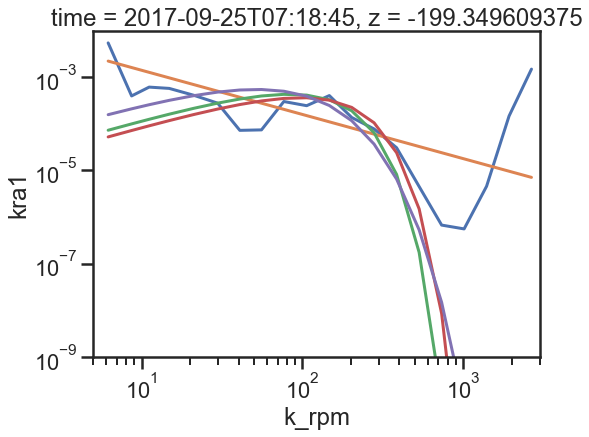

In [71]:
plt.figure(figsize=(8,6))
tms_block.corrdTdzsp1_rpm.plot()
tms_block.power1.plot()
tms_block.bat1.plot()
tms_block.bat1_rc.plot()
tms_block.kra1.plot()
plt.yscale('log')
plt.xscale('log')
plt.xlim(5e0,3e3)
plt.ylim(1e-9,1e-2)